In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
import os
import numpy.ma as ma
from collections import Counter
from dateutil.relativedelta import relativedelta


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
hfont = {'fontname':'Arial'}

In [3]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

In [4]:
key_regions = ["hippocampus", "parahippocampal", "entorhinal", "amygdala", "cingulate", "frontal", "occipital", "ventricle"]
def get_selected_cols(cols, key_regions):
    region_dict = {}
    cols_include = []
    for region in key_regions:
        region_dict[region] = [_ for _, col in enumerate(cols) if region in col.lower()]
        cols_include += region_dict[region]
    return cols_include

## Change the path to the pickled file

In [5]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/pickle_files/sim_tadpole19_subtype3.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [6]:
pkl["ml_subtype"].shape

(850, 1)

In [7]:
pkl["samples_likelihood"].shape

(2000000, 1)

### Check that the MCI and CN/AD files have same column names

In [8]:
# MCI and CN/AD data
cn_ad_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_cnad_no_5ventricle.csv"
df_cnad = pd.read_csv(cn_ad_path)
mci_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_mci_no_5_ventricle.csv"
df_mci = pd.read_csv(mci_path)
df_cnad["EXAMDATE"] = pd.to_datetime(df_cnad["EXAMDATE"])
df_mci["EXAMDATE"] = pd.to_datetime(df_mci["EXAMDATE"])
assert all(df_mci.columns == df_cnad.columns)

## Subtyping and Staging the subjects

### Get the probability matrices for CN/AD

In [9]:
# Get the mixture model for the CN/AD subjects
k=118
X = df_cnad.iloc[:,:k].values
bm_names = df_cnad.columns[:k].tolist()
y = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X, y)
L_yes = np.zeros(X.shape)
L_no = np.zeros(X.shape)
for i in range(k):
    L_no[:, i], L_yes[:, i] = mixture_models[i].pdfs_mixture_components(X[:, i], None)

L_no = process_L(L_no)
L_yes = process_L(L_yes)

/home/rtandon32/.conda/envs/sustain/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


### Create a SuStaIn object to call the associated methods

In [10]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [24,23,24,23,24]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 2
p_absorb = 0.3
N_em = 100
SuStaInLabels = df_cnad.columns[:k].tolist()
dataset_name            = 'sim_tadpole32'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes, L_no, n_stages, stage_sizes, min_clust_size, p_absorb, rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, N_iterations_MCMC, N_em, output_folder, dataset_name, use_parallel_startpoints)

### Get the prob mat for the mci subjects

In [11]:
# Get the prob mat for the mci subjects
X_mci = df_mci.iloc[:,:k].values
prob_mat_mci = mixture_model.get_prob_mat(X_mci, mixture_models)
L_no_mci = prob_mat_mci[:,:,0]
L_yes_mci = prob_mat_mci[:,:,1]
L_no_mci = process_L(L_no_mci)
L_yes_mci = process_L(L_yes_mci)

### Subtype and Stage the MCI subjects

In [12]:
# Subtype and Stage the MCI subjects
last_N = 2000000
N_samples = 1000
sustainData_newData = sEBMSustainData(L_yes_mci, L_no_mci, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci, ll = sustain.subtype_and_stage_individuals(sustainData_newData, shape_seq, samples_sequence, samples_f, N_samples)


In [13]:
np.mean(ll), np.std(ll)

(-774904.8248169948, 16.18766479605104)

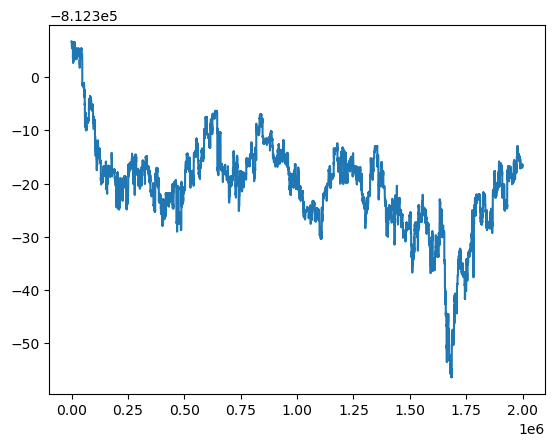

In [14]:
# plt.plot(ll)
plt.plot(pkl["samples_likelihood"])

### Subtype and Stage CN/AD data

In [15]:
# subtype and stage CN/AD data

sustainData_cnad = sEBMSustainData(L_yes, L_no, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]

ml_subtype_cnad, \
prob_ml_subtype_cnad, \
ml_stage_cnad, \
prob_ml_stage_cnad, \
prob_subtype_cnad, \
prob_stage_cnad, \
prob_subtype_stage_cnad, _ = sustain.subtype_and_stage_individuals(sustainData_cnad, shape_seq, samples_sequence, samples_f, N_samples)


In [16]:
n_cnad = ml_subtype_cnad.shape[0]
n_mci = ml_subtype_mci.shape[0]
unique_cnad, counts_cnad = np.unique(ml_subtype_cnad, return_counts=True)
unique_mci, counts_mci = np.unique(ml_subtype_mci, return_counts=True)

fraction_cnad = {}
dict_cnad = dict(zip(unique_cnad, counts_cnad))
for k, v in dict_cnad.items():
    fraction_cnad[k] = v/n_cnad
    
fraction_mci = {}
dict_mci = dict(zip(unique_mci, counts_mci))
for k, v in dict_mci.items():
    fraction_mci[k] = v/n_mci
    
print("CN/AD fractions across subtypes : \n", fraction_cnad)
print("MCI fractions across subtypes : \n", fraction_mci)

CN/AD fractions across subtypes : 
 {0.0: 0.4964705882352941, 1.0: 0.2611764705882353, 2.0: 0.14588235294117646, 3.0: 0.09647058823529411}
MCI fractions across subtypes : 
 {0.0: 0.49876237623762376, 1.0: 0.22400990099009901, 2.0: 0.1782178217821782, 3.0: 0.09900990099009901}


In [17]:
counts_cnad

array([422, 222, 124,  82])

### Get subjects for a givensubtype

### Prepare final dataframe which has subtype, stage, PTID, DX, and EXAMDATE for all subjects

In [18]:
# DataFrame for CN/AD subjects
array_subtype_stage_cnad = np.hstack([ml_subtype_cnad, ml_stage_cnad, y.values.reshape(-1,1)])
cnad_solved = pd.DataFrame(data=array_subtype_stage_cnad, columns=["subtype", "stage", "DX"])
cnad_solved[["PTID", "EXAMDATE"]] = df_cnad[["PTID", "EXAMDATE"]]

In [19]:
# DataFrame for MCI subjects
array_subtype_stage_mci = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_solved = pd.DataFrame(data=array_subtype_stage_mci, columns=["subtype", "stage"])
mci_solved["DX"] = 2.0
mci_solved[["PTID", "EXAMDATE"]] = df_mci[["PTID", "EXAMDATE"]]
final_df = pd.concat([cnad_solved, mci_solved], axis=0)

In [20]:
final_df["DX"] = final_df["DX"].map({0.0:"Controls", 1.0:"AD", 2.0:"MCI"})

In [21]:
def append_counts_bar(df, st_min=0, st_max=5):
    if df["stage"].min() > st_min:
        new_row = {"stage":0.0, "DX":"Controls", "value":0.0}
#         new_row = {"stage":0.0, "DX":"MCI", "value":0.0}
#         new_row = {"stage":0.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    if df["stage"].max() < st_max:
        new_row = {"stage":5.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    return df

In [31]:
subtype_select = 3
final_df_grouped = final_df[final_df["subtype"] == subtype_select].groupby(["stage", "DX"]).size().reset_index()
final_df_pivot = final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)
final_df_pivot /= final_df_pivot.sum(axis=0)
counts_bar = final_df_pivot.melt(ignore_index=False, value_vars=["Controls","AD","MCI"]).reset_index()

In [32]:
counts_bar = append_counts_bar(counts_bar)
counts_bar["stage"] = counts_bar["stage"].astype(int)

<ipython-input-21-d65cc012ca6a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-21-d65cc012ca6a>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


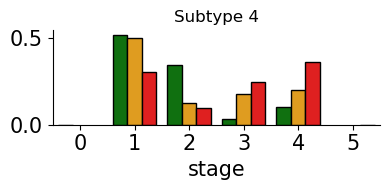

In [33]:
fig, ax = plt.subplots(figsize=(4,2))
hue_order=["Controls", "MCI", "AD"]
palette = ["g", "orange","r"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("stage", fontsize=15)
ax.set_ylabel("")
    
ax.get_legend().remove()

ax.tick_params(axis='both', which='major', labelsize=15)


# ax.set_ylim([0])
ax.set_title("Subtype {}".format(int(subtype_select+1)), fontsize=12)
sns.despine()
plt.tight_layout()
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/"
fname = "stage_hist_subtype_{}.png".format(int(subtype_select+1))
fig.savefig(os.path.join(fig_path, fname), dpi=300, transparent=True)


In [34]:
k=118
df_total = pd.concat([df_mci, df_cnad], axis=0)
SuStaIn_df = pd.merge(df_total, final_df, on=["PTID", "EXAMDATE"])
SuStaIn_df = SuStaIn_df[SuStaIn_df["DX_y"]=="MCI"]
MRI_cols = SuStaIn_df.columns.tolist()[:k]
SuStaIn_cols = MRI_cols + ["subtype", "stage"]
SuStaIn_df_rel = SuStaIn_df[SuStaIn_cols]
SuStaIn_df_rel["subtype"] += 1
# df_total

<ipython-input-34-21bc7edcfa55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SuStaIn_df_rel["subtype"] += 1


In [35]:
from sklearn.manifold import TSNE

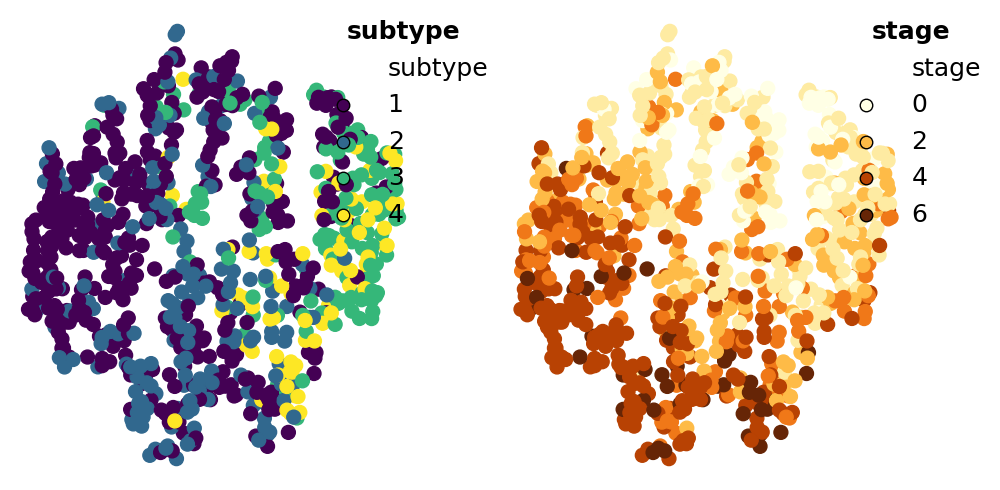

In [36]:
# palette="autumn_r",
SuStaIn_embedded = TSNE(n_components=2, learning_rate='auto',
                       init='pca', perplexity=30, random_state=0).fit_transform(SuStaIn_df_rel[MRI_cols].values)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                palette = "viridis", s = 100, ax = ax[0],edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["subtype"].astype(int))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                s = 100, ax = ax[1], palette="YlOrBr", edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["stage"].astype(int))
ax[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="subtype",
             title_fontproperties={'weight':'bold', 'size':18})
ax[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="stage",
             title_fontproperties={'weight':'bold', 'size':18})

for ha in ax[0].legend_.legendHandles:
    ha.set_edgecolor("k")

for ha in ax[1].legend_.legendHandles:
    ha.set_edgecolor("k")
    
# ax[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0., frameon=False)
ax[0].axis("off")
ax[1].axis("off")
fig.tight_layout()
fig.savefig(os.path.join(fig_path, "t-SNE_MCI_full.png"), dpi=400)


# Progression curves

In [37]:
# def prepare_longitudinal_data(first_visit_df):
#     # Read the MRI data across all subjects
#     path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm.csv"
#     df = pd.read_csv(path)
#     sid = df["Measure:volume"].apply(lambda x: x.split("-",1))
#     df_sid = pd.DataFrame(sid.tolist(), columns=["sid", "time"])
#     sid_time = df_sid["time"].apply(lambda x: x.split("_",1))
#     df_sid_time = pd.DataFrame(sid_time.tolist(), columns=["date", "time"])
#     df_concat = pd.concat([df_sid, df_sid_time], axis=1)[["sid", "date"]]
#     df_concat["date"] = pd.to_datetime(df_concat["date"])

#     # Read the ADNIMERGE file     
#     adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
#     df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]
#     df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])
#     merged_df = df_adnimerge.merge(df_concat, left_on=["PTID", "EXAMDATE"], right_on=["sid", "date"])
    
#     # longitudinal_records
#     longitudinal_records = df_adnimerge.sort_values(["PTID", "EXAMDATE"]).set_index("PTID").dropna(subset=["DX"])
#     d = {}
#     for i, row in first_visit_df.iterrows():
#         ptid = row["PTID"]
#         d[ptid] = longitudinal_records.loc[ptid, :]
#     return d, merged_df
    

In [38]:
def prepare_longitudinal_data_newL(first_visit_df):
    path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
    df = pd.read_csv(path)
    df.dropna(subset=["DX"], inplace=True)
    df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"])
    
    # longitudinal_records
    meta_cols = ["DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4", "PTID"]
    longitudinal_records = df.sort_values(["PTID", "EXAMDATE"]).dropna(subset=["DX"])[meta_cols]
    
    d = {}
    for i, row in first_visit_df.iterrows():
        ptid = row["PTID"]
        d[ptid] = longitudinal_records[longitudinal_records["PTID"].isin([ptid])].reset_index(drop=True)
    return d, longitudinal_records

In [39]:
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

In [40]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
mci_demographics = merged_df[merged_df["PTID"].isin(mci_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [47]:
Su = 3.0
mci_subtype = mci_solved[mci_solved["subtype"]==Su]
fraction_mci = mci_subtype.shape[0]/mci_solved.shape[0]
cox_mci = mci_demographics[mci_demographics["PTID"].isin(mci_subtype["PTID"])]
dict_stage = dict(zip(mci_subtype["PTID"],mci_subtype["stage"]))

<ipython-input-48-f4c3f0490ac6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mci_subtype["convert"] = mci_subtype["PTID"].map(d_convert)
<ipython-input-48-f4c3f0490ac6>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_mci["convert"] = cox_mci["PTID"].map(d_convert)
<ipython-input-48-f4c3f0490ac6>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

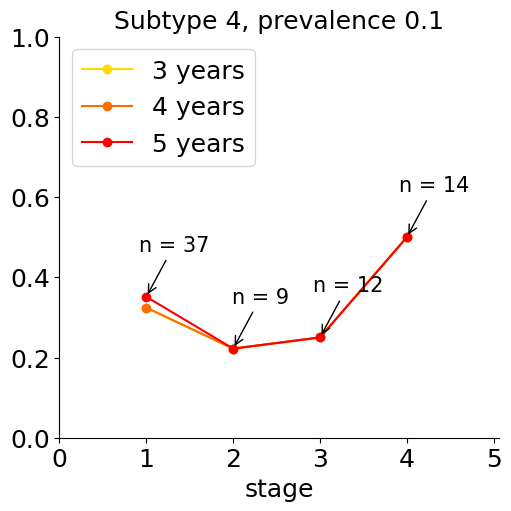

In [48]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in mci_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "MCI"
            bool_srs = srs == "Dementia"
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    mci_subtype["convert"] = mci_subtype["PTID"].map(d_convert)
    mci_subtype = mci_subtype[~mci_subtype["convert"].isna()]
    df_convert = mci_subtype[mci_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(mci_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(20, 30),
              textcoords='offset points', ha='center', va='bottom', fontsize=15,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_mci["convert"] = cox_mci["PTID"].map(d_convert)
    cox_mci["time"] = cox_mci["PTID"].map(d_timedelta)
    cox_mci["subtype"] = Su
    cox_mci["stages_inferred"] = cox_mci["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_mci.csv".format(Su,d_yr)
    cox_mci.to_csv(os.path.join(fig_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_mci, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,1])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "mci_subtype_{}.png".format(Su)
fig.savefig(os.path.join(fig_path, fig_name), dpi=450)


In [49]:
Counter(df_convert["stage"])

Counter({1.0: 13, 4.0: 7, 3.0: 3, 2.0: 2})

In [50]:
Counter(mci_subtype["stage"])

Counter({1.0: 37, 4.0: 14, 3.0: 12, 2.0: 9})

## Controls progression

In [51]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [58]:
Su = 3.0
cn_solved = cnad_solved[cnad_solved["DX"]==0.0]
cn_subtype = cn_solved[cn_solved["subtype"]==Su]
fraction_cn = cn_subtype.shape[0]/cn_solved.shape[0]
cox_cn = cn_demographics[cn_demographics["PTID"].isin(cn_subtype["PTID"])]
dict_stage = dict(zip(cn_subtype["PTID"],cn_subtype["stage"]))

<ipython-input-59-77f35944d08b>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cn_subtype["convert"] = cn_subtype["PTID"].map(d_convert)
<ipython-input-59-77f35944d08b>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_cn["convert"] = cox_cn["PTID"].map(d_convert)
<ipython-input-59-77f35944d08b>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

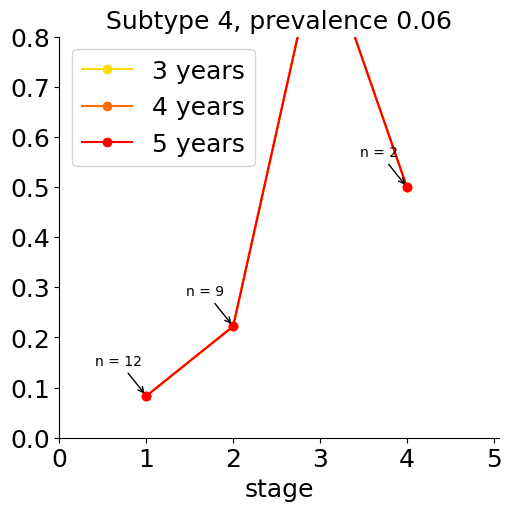

In [59]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in cn_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "CN"
            bool_srs = srs != first_dx
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    cn_subtype["convert"] = cn_subtype["PTID"].map(d_convert)
    cn_subtype = cn_subtype[~cn_subtype["convert"].isna()]
    df_convert = cn_subtype[cn_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(cn_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(-20, 20),
              textcoords='offset points', ha='center', va='bottom',
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_cn["convert"] = cox_cn["PTID"].map(d_convert)
    cox_cn["time"] = cox_cn["PTID"].map(d_timedelta)
    cox_cn["subtype"] = Su
    cox_cn["stages_inferred"] = cox_cn["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_cn.csv".format(Su,d_yr)
    cox_cn.to_csv(os.path.join(fig_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_cn, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,0.8])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "cn_subtype_{}.png".format(Su)
fig.savefig(os.path.join(fig_path, fig_name), dpi=450)


In [60]:
den_list

[nan, 12, 9, 1, 2, nan]

In [61]:
Counter(df_convert["stage"])

Counter({2.0: 2, 1.0: 1, 4.0: 1, 3.0: 1})

In [62]:
Counter(cn_subtype["stage"])

Counter({1.0: 12, 2.0: 9, 4.0: 2, 3.0: 1})

## Longitudinal data analysis

In [63]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
df_long = pd.read_csv(long_path)
df_long.dropna(subset=["DX"], inplace=True)
df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])

In [64]:
df_long.shape

(4851, 130)

In [65]:
len(set(df_long["sid"]))

1698

In [66]:
# set(df_long["sid"])-set(final_df["PTID"])

In [67]:
len(set(final_df["PTID"]))

1658

In [68]:
k=118
all(df_long.columns[:k] == df_cnad.columns[:k])

True

In [69]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [70]:
d, merged_df = prepare_longitudinal_data_newL(final_df)

In [71]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [72]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [73]:
# Subtype and Stage the MCI subjects
last_N = 2000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)


In [74]:
df_long_mci

,3rd-Ventricle,4th-Ventricle,Brain-Stem,CC_Anterior,CC_Central,CC_Mid_Anterior,CC_Mid_Posterior,CC_Posterior,CSF,CortexVol,...,DX,DX_bl,EXAMDATE,PTEDUCAT,PTGENDER,PTID,VISCODE,align_err_days,date,sid
8,1195,2162,19174,793,375,470,373,951,1196,362633.6324,...,MCI,LMCI,2007-02-22,16,Female,002_S_0729,m06,0,2/22/07,002_S_0729
9,1194,2367,18589,742,363,451,380,967,1147,356261.5890,...,Dementia,LMCI,2007-09-05,16,Female,002_S_0729,m12,0,9/5/07,002_S_0729
10,1385,1975,18176,685,342,424,377,920,1345,343581.5121,...,Dementia,LMCI,2008-08-28,16,Female,002_S_0729,m24,32,9/29/08,002_S_0729
11,1296,2414,18427,747,330,444,365,933,1346,347791.0260,...,Dementia,LMCI,2009-08-13,16,Female,002_S_0729,m36,0,8/13/09,002_S_0729
12,1941,1887,22956,813,325,328,337,836,1599,400365.4588,...,MCI,LMCI,2007-03-28,16,Male,002_S_0782,m06,14,4/11/07,002_S_0782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5541,1249,1699,19661,764,407,447,366,1004,1655,429010.9442,...,MCI,EMCI,2012-10-04,18,Male,941_S_4420,m06,78,12/21/12,941_S_4420
5542,1228,1656,19361,758,412,434,372,992,1768,424499.9782,...,MCI,EMCI,2013-03-25,18,Male,941_S_4420,m12,0,3/25/13,941_S_4420
5543,3234,3131,20749,476,273,197,202,755,2035,385137.6643,...,MCI,EMCI,2012-06-11,20,Female,941_S_4764,bl,10,6/1/12,941_S_4764
5545,3328,3418,20491,459,247,205,204,741,2233,378188.3252,...,MCI,EMCI,2013-06-10,20,Female,941_S_4764,m12,0,6/10/13,941_S_4764


In [75]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_long_subtype_stage = pd.DataFrame(mci_long_subtype_stage, columns=["subtype", "stage"])
mci_long_subtype_stage[["sid", "date"]] = df_long_mci.reset_index(drop=True)[["sid", "date"]]
mci_long_subtype_stage["date"] = pd.to_datetime(mci_long_subtype_stage["date"])
df_followup = mci_long_subtype_stage
df_followup = df_followup.sort_values(["sid", "date"])

In [76]:
def get_pairs(vec):
    trns = []
    l = vec.shape[0]
    for i in range(1,l):
        trns.append((vec[:i][-1], vec[i:][0]))
    return trns

sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["subtype"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-76-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [77]:
count = np.zeros((4,4))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

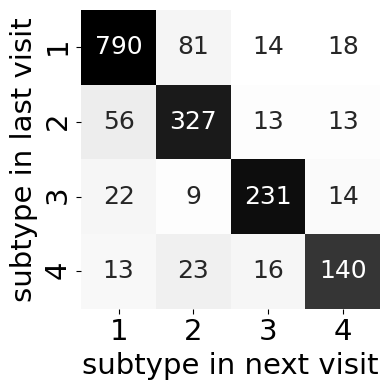

In [78]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("subtype in last visit", fontsize=21)
ax.set_xlabel("subtype in next visit", fontsize=21)
ax.set_xticklabels([1,2,3,4], fontsize=21)
ax.set_yticklabels([1,2,3,4], fontsize=21)
fig_name = "longitudinal_subtype_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [79]:
count.trace() , count.sum()

(1488, 1780)

In [80]:
count.trace()/count.sum()

0.8359550561797753

## Stage transition matrix

In [81]:
sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["stage"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-81-357e31660e85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [82]:
count = np.zeros((6,6))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

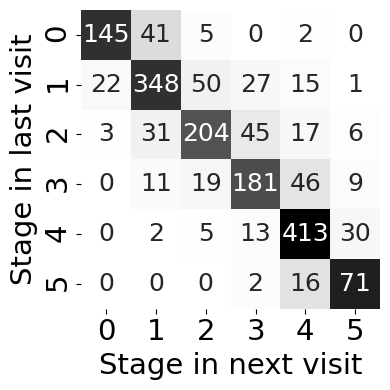

In [83]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("Stage in last visit", fontsize=21)
ax.set_xlabel("Stage in next visit", fontsize=21)
ax.set_xticklabels([0,1,2,3,4,5], fontsize=21)
ax.set_yticklabels([0,1,2,3,4,5], fontsize=21)
fig_name = "longitudinal_stage_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [84]:
x_ = np.array([0.35,0.27,0.15,0.23])
np.dot(x_,x_)

0.2708

In [85]:
mci_long_subtype_stage[["sid", "date"]]

,sid,date
0,002_S_0729,2007-02-22
1,002_S_0729,2007-09-05
2,002_S_0729,2008-09-29
3,002_S_0729,2009-08-13
4,002_S_0782,2007-04-11
...,...,...
2583,941_S_4420,2012-12-21
2584,941_S_4420,2013-03-25
2585,941_S_4764,2012-06-01
2586,941_S_4764,2013-06-10


In [ ]:
df_long_mci

In [ ]:
mci_demographics, mci_solved

In [ ]:
mci_solved["EXAMDATE"]

In [ ]:
mci_demo_full = pd.merge(mci_demographics, mci_solved, on=["PTID", "EXAMDATE"])

In [ ]:
mci_solved

In [ ]:
final_df

In [ ]:
mci_demo_full.head()

In [ ]:
mci_demo_full

In [ ]:
mci_demo_full.groupby(["subtype", "APOE4"]).size()

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='stage', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_demographics = merged_df[merged_df["DX"].isin(["CN", "MCI", "Dementia"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
len(set(all_demographics["PTID"]))

In [ ]:
all_demographics

In [ ]:
all_data = pd.merge(all_demographics, final_df, on=["PTID", "EXAMDATE"])

In [ ]:
all_data.pivot_table(index='subtype', columns='DX_x', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data[all_data["DX_x"].isin(["CN", "Dementia"])].pivot_table(index='subtype', columns='PTGENDER', 
                        aggfunc=len, fill_value=0)["PTID"]

# Scrap Analysis

In [ ]:
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/df12_longitudinal_ebm.csv"
df_long = pd.read_csv(long_path)

In [ ]:
len(set(df_adnimerge["PTID"].tolist()))

In [ ]:
len(set(df_long["sid"].tolist()))

In [ ]:
327 + 551

In [ ]:
cols = df_mci.columns[:k].tolist()